Fitting 5 folds for each of 5 candidates, totalling 25 fits
Millor alpha (Ridge) trobat amb cross-val sobre TRAIN: 100.0

--- AVALUACIÓ EN VALIDATION SET ---
Validation   → MSE: 57.3580 | MAE: 6.2221 | R²: 0.8370 | MAPE: 4.14%

--- AVALUACIÓ EN TEST SET (Reentrenat amb Train+Val) ---
Test         → MSE: 166.3312 | MAE: 10.3104 | R²: 0.5283 | MAPE: 5.18%


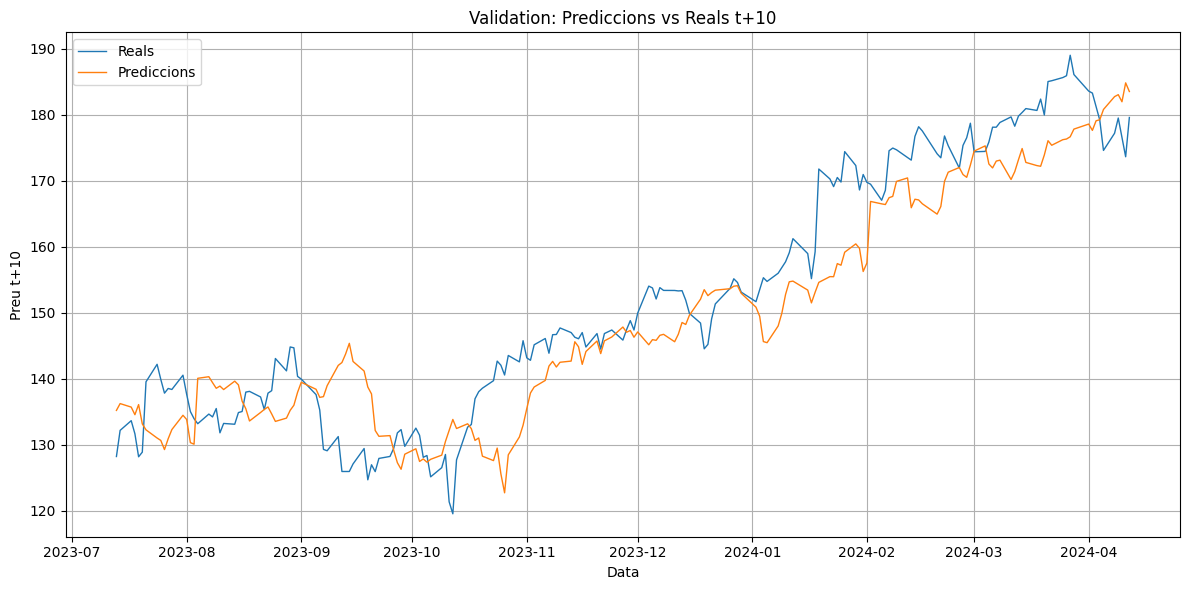

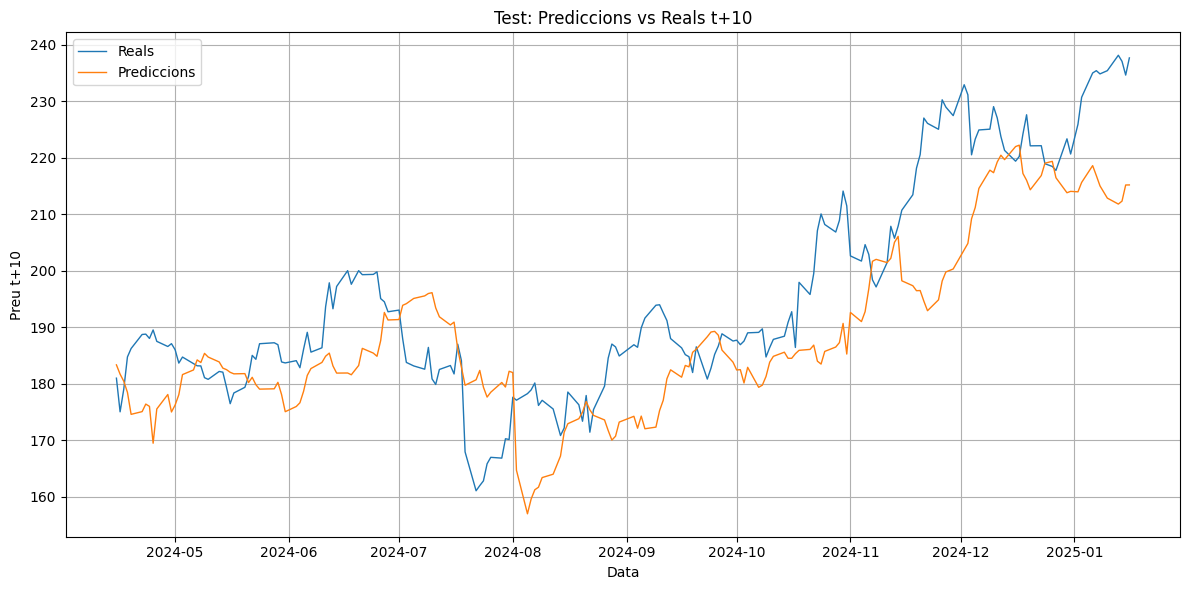


Model final guardat a:
C:\Users\jesus\Desktop\TFG\Models\ridge_model_amazon.joblib


In [6]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ------------------------------------------------------------
# CONFIGURACIÓ D’ENTORN I PATHS
# ------------------------------------------------------------
BASE_PATH = r"C:\Users\jesus\Desktop\TFG\GitHUb\TFG_PredictStock\Conjunt de dades Preprocessades\Datasets"
FILE_NAME = "Amazon_Stock_Price_output.csv"
MODEL_OUTPUT_PATH = r"C:\Users\jesus\Desktop\TFG\Models"
os.makedirs(MODEL_OUTPUT_PATH, exist_ok=True)
MODEL_FILENAME = os.path.join(MODEL_OUTPUT_PATH, "ridge_model_amazon.joblib")

# ------------------------------------------------------------
# FUNCIONS AUXILIARS
# ------------------------------------------------------------
def load_and_prepare_data(csv_path, horizon=10, base_features=None):
    """
    Llegeix el CSV, ordena per data, afegeix el target t+horizon i retorna X, y.
    """
    df = pd.read_csv(csv_path)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=False)
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)

    # Si no es passen features, s'utilitzen aquestes per defecte
    if base_features is None:
        base_features = [
            'Open', 'High', 'Low', 'Volume',
            'EMA_7', 'EMA_40', 'MACD', 'Signal_Line',
            'MACD_Hist', 'RSI', 'ATR'
        ]

    # Creació del target a 10 dies
    df['Target_Close_t_plus_10'] = df['Close'].shift(-horizon)

    # Eliminar files sense target
    df = df.dropna(subset=['Target_Close_t_plus_10']).reset_index(drop=True)

    X = df[base_features].copy()
    y = df['Target_Close_t_plus_10'].copy()

    return X, y, df

def train_val_test_split_time_series(X, y, train_frac=0.70, val_frac=0.15):
    """
    Fa split cronològic: train, validation i test.
    """
    n_total = len(X)
    split_train = int(n_total * train_frac)
    split_val = int(n_total * (train_frac + val_frac))

    X_train = X.iloc[:split_train].reset_index(drop=True)
    y_train = y.iloc[:split_train].reset_index(drop=True)

    X_val = X.iloc[split_train:split_val].reset_index(drop=True)
    y_val = y.iloc[split_train:split_val].reset_index(drop=True)

    X_test = X.iloc[split_val:].reset_index(drop=True)
    y_test = y.iloc[split_val:].reset_index(drop=True)

    return X_train, y_train, X_val, y_val, X_test, y_test

def evaluate_model(model, X, y_true, subset_name="Subset"):
    """
    Calcula MSE, MAE, R2 i MAPE, i imprimeix per subset.
    Retorna prediccions i diccionari de mètriques.
    """
    preds = model.predict(X)
    mse = mean_squared_error(y_true, preds)
    mae = mean_absolute_error(y_true, preds)
    r2  = r2_score(y_true, preds)
    mape = np.mean(np.abs((y_true - preds) / y_true)) * 100

    print(f"{subset_name:12s} → MSE: {mse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f} | MAPE: {mape:.2f}%")
    return preds, {'mse': mse, 'mae': mae, 'r2': r2, 'mape': mape}

def plot_predictions(df_full, y_true, y_pred, split_index, title="Prediccions vs Reals"):
    """
    Plota en un gràfic els valors reals vs. prediccions a partir d'un DataFrame complet
    i l'índex on comença el subset (per exemple, inici del test o valid).
    """
    dates = df_full['Date'].iloc[split_index:split_index+len(y_true)]
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_true.values, label='Reals', linewidth=1)
    plt.plot(dates, y_pred,     label='Prediccions', linewidth=1)
    plt.xlabel("Data")
    plt.ylabel("Preu t+10")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------
# 1. CARREGAR I PREPARAR DADES
# ------------------------------------------------------------
csv_path = os.path.join(BASE_PATH, FILE_NAME)
base_features = [
    'Open', 'High', 'Low', 'Volume',
    'EMA_7', 'EMA_40', 'MACD', 'Signal_Line',
    'MACD_Hist', 'RSI', 'ATR'
]
X, y, df_full = load_and_prepare_data(csv_path, horizon=10, base_features=base_features)

# ------------------------------------------------------------
# 2. SPLIT CRONOLÒGIC
# ------------------------------------------------------------
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split_time_series(X, y)

# ------------------------------------------------------------
# 3. PIPELINE I GRID SEARCH AMB CROSS-VALIDATION TEMPORAL
# ------------------------------------------------------------
# Definim Pipeline: escalar + model Ridge
from sklearn.pipeline import Pipeline

random_state = 42  # per reproducibilitat

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(random_state=random_state))
])

param_grid = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

# Fem TimeSeriesSplit exclusivament sobre TRAIN
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['ridge__alpha']
print(f"Millor alpha (Ridge) trobat amb cross-val sobre TRAIN: {best_alpha}")

# Recuperem el millor pipeline
best_pipeline = grid_search.best_estimator_

# ------------------------------------------------------------
# 4. AVALUACIÓ SOBRE VALIDATION
# ------------------------------------------------------------
print("\n--- AVALUACIÓ EN VALIDATION SET ---")
preds_val, metrics_val = evaluate_model(best_pipeline, X_val, y_val, subset_name="Validation")

# Si vols, pots decidir reentrenar el model sobre TRAIN+VALIDATION abans de fer el test final
# Per exemple, recomanable si l’objectiu és obtenir el millor model possible
# Construïm un pipeline nou amb el millor alpha i el reentrenem
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=best_alpha, random_state=random_state))
])
X_train_val = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
y_train_val = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)
final_pipeline.fit(X_train_val, y_train_val)

# ------------------------------------------------------------
# 5. AVALUACIÓ FINAL SOBRE TEST
# ------------------------------------------------------------
print("\n--- AVALUACIÓ EN TEST SET (Reentrenat amb Train+Val) ---")
preds_test, metrics_test = evaluate_model(final_pipeline, X_test, y_test, subset_name="Test")

# ------------------------------------------------------------
# 6. PLOT DE RESULTATS (VAL I TEST)
# ------------------------------------------------------------
# Obtenim l'índex numerós on comença validation i test en df_full
split_train_idx = len(X_train)
split_val_idx = split_train_idx + len(X_val)

# Plot Validation (només per consistència si vols comparar directament)
plot_predictions(df_full, y_val, preds_val, split_train_idx, title="Validation: Prediccions vs Reals t+10")

# Plot Test
plot_predictions(df_full, y_test, preds_test, split_val_idx, title="Test: Prediccions vs Reals t+10")

# ------------------------------------------------------------
# 7. GUARDAT DEL MODEL FINAL
# ------------------------------------------------------------
joblib.dump(final_pipeline, MODEL_FILENAME)
print(f"\nModel final guardat a:\n{MODEL_FILENAME}")


In [7]:
import os
import joblib
import numpy as np
import pandas as pd
import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ------------------------------------------------------------
# CONFIGURACIÓ D’ENTORN I PATHS
# ------------------------------------------------------------
BASE_PATH = r"C:\Users\jesus\Desktop\TFG\GitHUb\TFG_PredictStock\Conjunt de dades Preprocessades\Datasets"
DATASETS = [
    "Amazon_Stock_Price_output.csv",
    "Euro_Stoxx_50_Stock_Price_output.csv",
    "Google_Stock_Price_output.csv",
    "Hang_Seng_Stock_Price_output.csv",
    "IBEX_35_Stock_Price_output.csv",
    "Indra_Stock_Price_output.csv",
    "P&G_Stock_Price_output.csv",
    "S&P500_Stock_Price_output.csv"
]

BASE_RESULTS_FOLDER = r"C:\Users\jesus\Desktop\TFG\GitHUb\TFG_PredictStock\RIDGE\resultats_RIDGE"
os.makedirs(BASE_RESULTS_FOLDER, exist_ok=True)

# Paràmetres de grid per Ridge
RIDGE_PARAM_GRID = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
}

RANDOM_STATE = 42

# ------------------------------------------------------------
# FUNCIONS AUXILIARS
# ------------------------------------------------------------
def load_and_prepare_data(csv_path, horizon=10, base_features=None):
    """
    Llegeix el CSV, ordena per 'Date', crea target t+horizon i retorna X, y, df_suport.
    """
    df = pd.read_csv(csv_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)

    if base_features is None:
        base_features = [
            'Open', 'High', 'Low', 'Volume',
            'EMA_7', 'EMA_40', 'MACD', 'Signal_Line',
            'MACD_Hist', 'RSI', 'ATR'
        ]

    # Creació del target a 10 dies
    df['Target_Close_t_plus_10'] = df['Close'].shift(-horizon)
    df = df.dropna(subset=['Target_Close_t_plus_10']).reset_index(drop=True)

    X = df[base_features].copy()
    y = df['Target_Close_t_plus_10'].copy()
    return X, y, df

def train_val_test_split_time_series(X, y, train_frac=0.70, val_frac=0.15):
    """
    Fa split cronològic en train (70%), validation (15%), test (15%).
    Retorna X_train, y_train, X_val, y_val, X_test, y_test.
    """
    n_total = len(X)
    split_train = int(n_total * train_frac)
    split_val = int(n_total * (train_frac + val_frac))

    X_train = X.iloc[:split_train].reset_index(drop=True)
    y_train = y.iloc[:split_train].reset_index(drop=True)

    X_val = X.iloc[split_train:split_val].reset_index(drop=True)
    y_val = y.iloc[split_train:split_val].reset_index(drop=True)

    X_test = X.iloc[split_val:].reset_index(drop=True)
    y_test = y.iloc[split_val:].reset_index(drop=True)

    return X_train, y_train, X_val, y_val, X_test, y_test

def evaluate_and_save_metrics(model, X, y_true, subset_name, metrics_folder, dataset_name):
    """
    Avaluar el model sobre (X, y_true), guardar mètriques a CSV i retornar prediccions i index de mètriques.
    """
    preds = model.predict(X)
    mse = mean_squared_error(y_true, preds)
    mae = mean_absolute_error(y_true, preds)
    r2  = r2_score(y_true, preds)

    df_metrics = pd.DataFrame({
        "Model": [f"Ridge_{subset_name}"],
        "MSE": [mse],
        "MAE": [mae],
        "R2": [r2]
    })
    metrics_path = os.path.join(metrics_folder, f"{dataset_name}_{subset_name.lower()}_metrics.csv")
    df_metrics.to_csv(metrics_path, index=False)

    return preds

def plot_real_vs_pred(df_dates, y_true, y_pred, title, output_path):
    """
    Plota les sèries reals i prediccions en HTML via Plotly i el desa a output_path.
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_dates,
        y=y_true,
        mode='lines',
        name='Reals',
        line=dict(color='blue')
    ))
    fig.add_trace(go.Scatter(
        x=df_dates,
        y=y_pred,
        mode='lines',
        name='Prediccions',
        line=dict(color='red', dash='dash')
    ))
    fig.update_layout(
        title=title,
        xaxis_title='Data',
        yaxis_title='Preu t+10',
        template='plotly_dark',
        xaxis_rangeslider_visible=True
    )
    fig.write_html(output_path)

# ------------------------------------------------------------
# PROCÉS PER A CADA DATASET
# ------------------------------------------------------------
for file_name in DATASETS:
    # 1. Rutes i carpetes
    file_path = os.path.join(BASE_PATH, file_name)
    dataset_name = os.path.splitext(file_name)[0]
    result_subfolder = os.path.join(BASE_RESULTS_FOLDER, dataset_name)
    os.makedirs(result_subfolder, exist_ok=True)

    # 2. Carregar i preparar dades
    X, y, df_full = load_and_prepare_data(file_path, horizon=10)
    dates_full = df_full['Date'].reset_index(drop=True)

    # 3. Split cronològic
    X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split_time_series(X, y)

    # 4. GridSearchCV amb Pipeline (StandardScaler + Ridge)
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(random_state=RANDOM_STATE))
    ])
    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(
        pipe,
        param_grid=RIDGE_PARAM_GRID,
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train, y_train)
    best_alpha = grid_search.best_params_['ridge__alpha']

    # 5. Entrenar model amb millor alpha sobre TRAIN
    best_pipeline = grid_search.best_estimator_

    # 6. Avaluar sobre VALIDATION i desar mètriques
    preds_val = evaluate_and_save_metrics(
        best_pipeline, X_val, y_val,
        subset_name="Validation",
        metrics_folder=result_subfolder,
        dataset_name=dataset_name
    )

    # 7. Entrenar model final sobre TRAIN+VALIDATION
    final_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=best_alpha, random_state=RANDOM_STATE))
    ])
    X_train_val = pd.concat([X_train, X_val], axis=0).reset_index(drop=True)
    y_train_val = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)
    final_pipeline.fit(X_train_val, y_train_val)

    # 8. Avaluar sobre TEST i desar mètriques
    preds_test = evaluate_and_save_metrics(
        final_pipeline, X_test, y_test,
        subset_name="Test",
        metrics_folder=result_subfolder,
        dataset_name=dataset_name
    )

    # 9. Desar el model final
    model_path = os.path.join(result_subfolder, f"{dataset_name}_ridge_model.joblib")
    joblib.dump(final_pipeline, model_path)

    # 10. Plots reals vs prediccions (Validation i Test) i desar com HTML
    split_train_idx = len(X_train)
    split_val_idx = split_train_idx + len(X_val)

    # Validation
    dates_val = dates_full.iloc[split_train_idx:split_val_idx].reset_index(drop=True)
    plot_real_vs_pred(
        df_dates=dates_val,
        y_true=y_val.reset_index(drop=True),
        y_pred=preds_val,
        title=f"{dataset_name} – Reals vs Prediccions (Validation, Ridge)",
        output_path=os.path.join(result_subfolder, f"{dataset_name}_validation_plot.html")
    )

    # Test
    dates_test = dates_full.iloc[split_val_idx:].reset_index(drop=True)
    plot_real_vs_pred(
        df_dates=dates_test,
        y_true=y_test.reset_index(drop=True),
        y_pred=preds_test,
        title=f"{dataset_name} – Reals vs Prediccions (Test, Ridge)",
        output_path=os.path.join(result_subfolder, f"{dataset_name}_test_plot.html")
    )

    print(f"Finalitzat: {dataset_name}. Resultats a {result_subfolder}")

print("Procés complet finalitzat per a tots els datasets.")


Finalitzat: Amazon_Stock_Price_output. Resultats a C:\Users\jesus\Desktop\TFG\GitHUb\TFG_PredictStock\RIDGE\resultats_RIDGE\Amazon_Stock_Price_output
Finalitzat: Euro_Stoxx_50_Stock_Price_output. Resultats a C:\Users\jesus\Desktop\TFG\GitHUb\TFG_PredictStock\RIDGE\resultats_RIDGE\Euro_Stoxx_50_Stock_Price_output
Finalitzat: Google_Stock_Price_output. Resultats a C:\Users\jesus\Desktop\TFG\GitHUb\TFG_PredictStock\RIDGE\resultats_RIDGE\Google_Stock_Price_output
Finalitzat: Hang_Seng_Stock_Price_output. Resultats a C:\Users\jesus\Desktop\TFG\GitHUb\TFG_PredictStock\RIDGE\resultats_RIDGE\Hang_Seng_Stock_Price_output
Finalitzat: IBEX_35_Stock_Price_output. Resultats a C:\Users\jesus\Desktop\TFG\GitHUb\TFG_PredictStock\RIDGE\resultats_RIDGE\IBEX_35_Stock_Price_output
Finalitzat: Indra_Stock_Price_output. Resultats a C:\Users\jesus\Desktop\TFG\GitHUb\TFG_PredictStock\RIDGE\resultats_RIDGE\Indra_Stock_Price_output
Finalitzat: P&G_Stock_Price_output. Resultats a C:\Users\jesus\Desktop\TFG\GitHU